# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import cv2
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import time

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from scipy.misc import imread
from scipy.linalg import norm
from scipy import sum, average

## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
# sys.path.append("C:\tensorflow\models\research\object_detection\\")
# sys.path.append("C:\tensorflow\models\research\\")

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [4]:
# What model we are using
MODEL_NAME = 'faster_rcnn_resnet101_coco'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = os.path.join('exported-model-02','frozen_inference_graph.pb')

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('label_map.pbtxt')

NUM_CLASSES = 1

## Download Model

In [ ]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
    file_name = os.path.basename(file.name)
    if 'frozen_inference_graph.pb' in file_name:
        tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [6]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [7]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Static image crater detection

In [8]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test-images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 9) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

3.8576159477233887
0.4833376407623291
0.491649866104126
0.4961519241333008
0.40193605422973633
0.3918592929840088
0.4121420383453369
0.4186699390411377


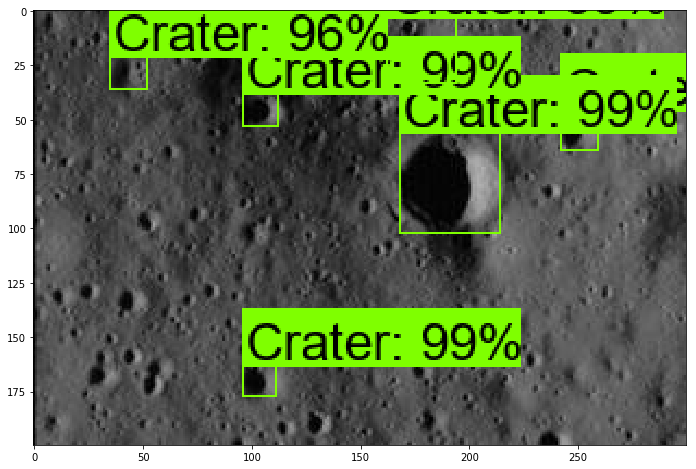

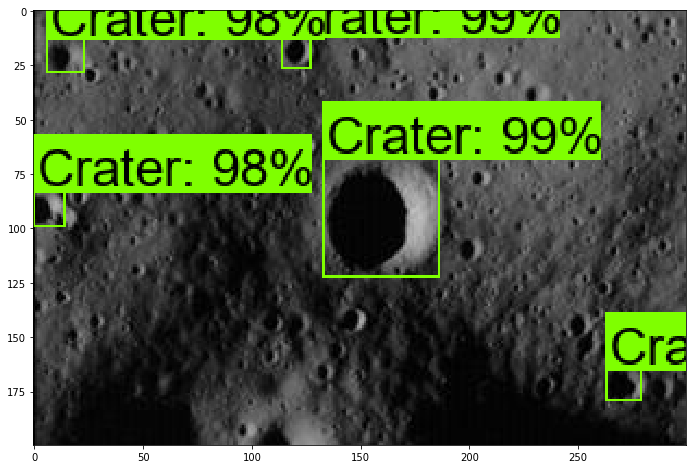

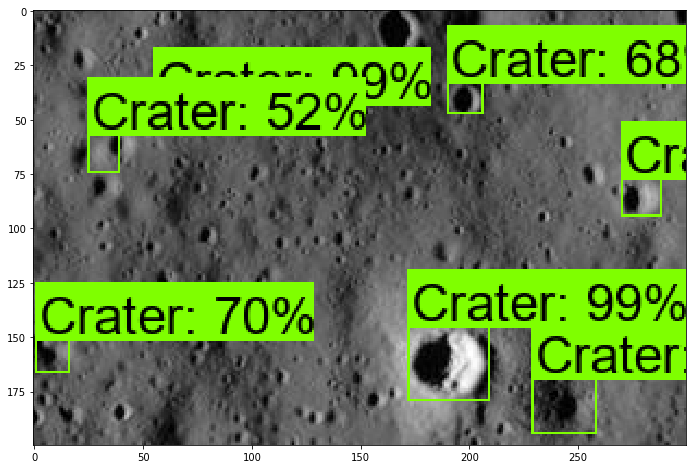

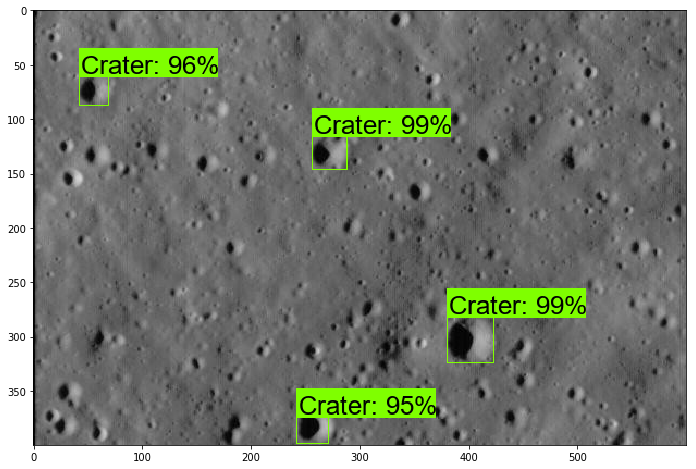

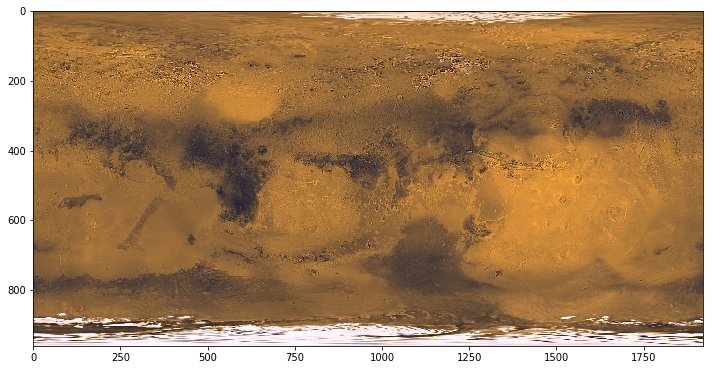

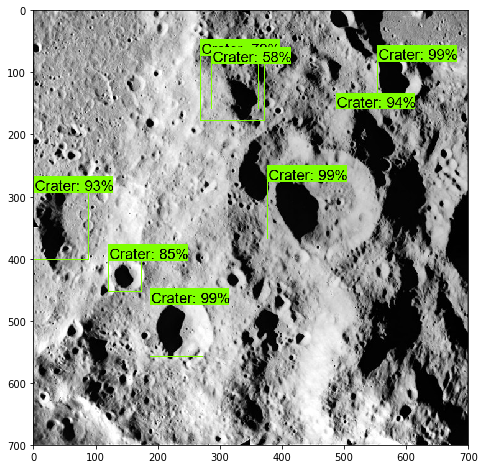

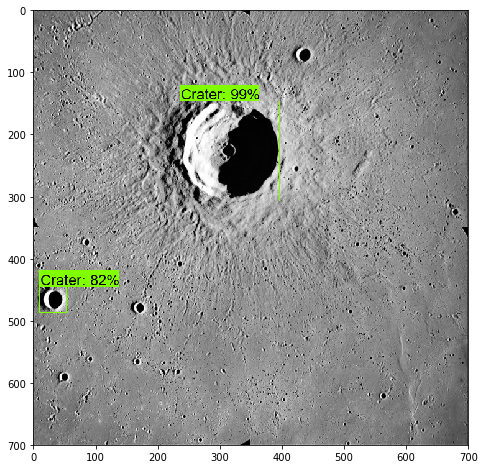

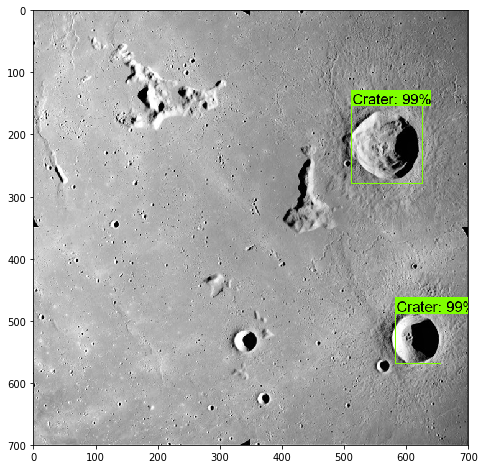

In [13]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')        
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            image = image.convert("RGB")
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            # Actual detection.
            start = time.time()
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            # Visualization of the results of a detection.
            end = time.time()
            print(end - start)
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=1)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)

# Crater detection in video

In [9]:
vid = 'video1.mp4'
video_path = os.path.join(PATH_TO_TEST_IMAGES_DIR, vid)

In [12]:
snapshots = []

def least_square_diff(img1, img2):
    
    dist_euclidean = np.sqrt(np.mean((img1 - img2) ** 2))    
    err = np.absolute(dist_euclidean)    
    return err

def get_tag(img, coords):
    # Gets tag for the image
    # Loop through existing images in snapshot and compares against each of them
    
    tag = None
    img = Image.fromarray(np.uint8(img)).convert('LA')
    print(coords)
    img = img.crop((int(coords[0]), int(coords[2]), int(coords[1]), int(coords[3])))
    
    
    for i, im in enumerate(snapshots):
        # Resize our image
        img_temp = img.resize(im.size, Image.ANTIALIAS)
        img_temp = np.array(img_temp)
        img_temp = np.fft.rfft2(img_temp)
        # compare image
        im = np.array(im)
        im = np.fft.rfft2(im)
        err = least_square_diff(img_temp, im)
        print("Error " + str(err))
        if err < 100:
            tag = i + 1
            break
    
    if tag == None:
        tag = len(snapshots) + 1
        snapshots.append(img)
    
    return tag

def get_bounding_box(image,boxes, scores, max_boxes_to_draw=20, min_score_thresh=.5):
    # Create a display string (and color) for every box location, group any boxes
    # that correspond to the same location.
    box_to_color_map = defaultdict(str)
    indices = []
    for i in range(min(max_boxes_to_draw, boxes.shape[0])):
        if scores is None or scores[i] > min_score_thresh:
            indices.append(i)
            box = tuple(boxes[i].tolist())
            box_to_color_map[box] = 'black'

    # Draw all boxes onto image.
    results = []
    image = Image.fromarray(np.uint8(image)).convert('RGB')
    im_width, im_height = image.size
    for box, color in box_to_color_map.items():
        ymin, xmin, ymax, xmax = box
        coord = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
        results.append(coord)
    
    return indices, results

In [ ]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        
        cap = cv2.VideoCapture(video_path)

        while True:
            ret, image_np = cap.read()
            image_np_expanded = np.expand_dims(image_np, axis=0)
            # Actual detection.
            #start = time.time()
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            # Visualization of the results of a detection.
            indices, bboxes = get_bounding_box(image_np, np.squeeze(boxes), np.squeeze(scores))
            tags = [0] * np.shape(np.squeeze(scores))[0]
            for ix, box in enumerate(bboxes):
                tag_x = get_tag(image_np, box)
                print(tag_x)
                tags[indices[ix]] = tag_x
            #end = time.time()
            #print(end - start)
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                scores=np.squeeze(scores),
                category_index=category_index,
                use_normalized_coordinates=True,
                line_thickness=1,
                id_tag=tags)
            # Show video
            cv2.imshow('Crater Detector', cv2.resize(image_np, (800,600)))
            if cv2.waitKey(25) & 0xFF == ord('q'):
                cv2.destroyAllWindows()
                break

(627.3212796449661, 680.3237369060516, 391.73208475112915, 454.17587757110596)
1
(622.1901458501816, 681.0744959115982, 382.8376293182373, 450.3037691116333)
Error 53.1068106116
1
(617.3862859010696, 681.7069227695465, 378.91860008239746, 450.42625665664673)
Error 32.7176472938
1
(618.0676975250244, 677.5126737356186, 371.8019127845764, 435.6996774673462)
Error 127.281714793
2
(604.3688501119614, 674.0057243108749, 357.07104206085205, 433.3463788032532)
Error 79.5042177178
1
(599.9293092489243, 668.3995854854584, 353.1901717185974, 428.7976026535034)
Error 92.0833818143
1
(591.8980973958969, 661.7064591646194, 349.9956250190735, 424.24163818359375)
Error 92.162813146
1
(582.9277518987656, 646.3325617313385, 344.51208114624023, 418.09362173080444)
Error 80.4396648584
1
(571.0459612607956, 643.9860769510269, 336.84550523757935, 413.70813846588135)
Error 117.868974875
Error 101.253935109
3
(568.2178883552551, 638.221984744072, 333.9113116264343, 406.76926374435425)
Error 89.0457346376
1
(